In [141]:
# Data preparation and Exploration
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('exchange_rate.csv', parse_dates=['date'], index_col='date')
df.head()

,Ex_rate
date,
01-01-1990 00:00,0.7855
02-01-1990 00:00,0.7818
03-01-1990 00:00,0.7867
04-01-1990 00:00,0.7860
05-01-1990 00:00,0.7849


In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7588 entries, 01-01-1990 00:00 to 10-10-2010 00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6+ KB


In [145]:
df.shape

(7588, 1)

In [147]:
# Ensure the index is a DatetimeIndex
if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index, format='%d-%m-%Y %H:%M')

In [149]:
df = df.asfreq('ME')

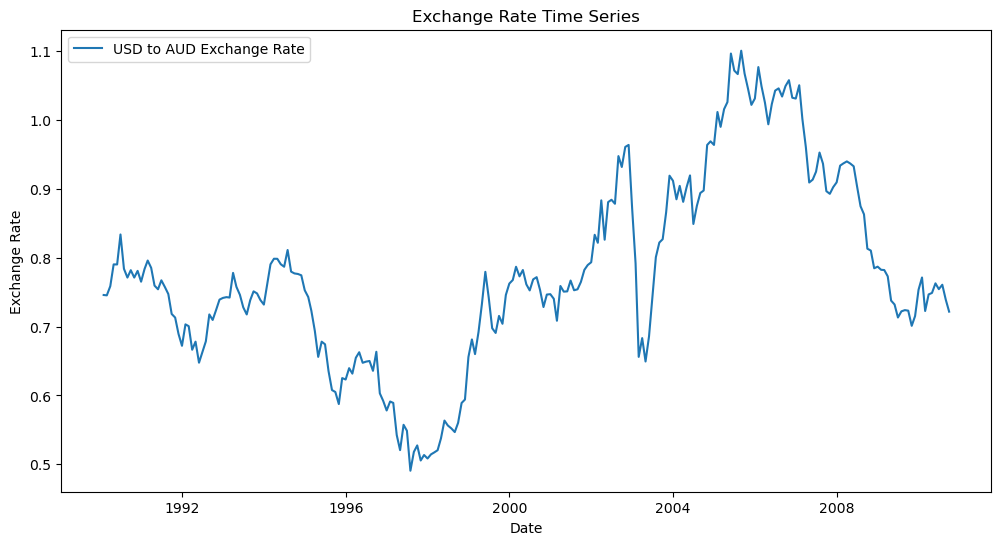

In [151]:
# Initial Exploration 
import matplotlib.pyplot as plt

# Plotting the time series
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='USD to AUD Exchange Rate')
plt.title('Exchange Rate Time Series')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [153]:
# Data Preprocessing
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values:", missing_values,"\n")

# Fill missing values with forward fill method
df['Ex_rate'] = df['Ex_rate'].ffill()

# Recheck for any remaining missing values
print("Missing values after filling:", df.isnull().sum(),"\n")

Missing values: Ex_rate    0
dtype: int64 

Missing values after filling: Ex_rate    0
dtype: int64 



In [155]:
# Handling Anomalies 
Q1 = df['Ex_rate'].quantile(0.25)
Q3 = df['Ex_rate'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify potential outliers
outliers = df[(df['Ex_rate'] < lower_bound) | (df['Ex_rate'] > upper_bound)]
print(outliers)

Empty DataFrame
Columns: [Ex_rate]
Index: []


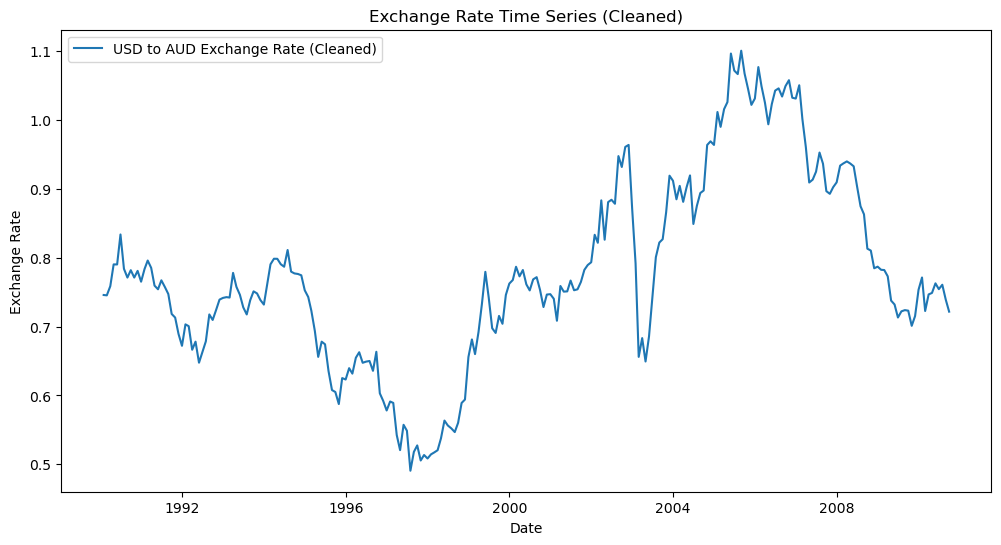

In [157]:
# Plot the cleaned time series again to visualize the changes
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='USD to AUD Exchange Rate (Cleaned)')
plt.title('Exchange Rate Time Series (Cleaned)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

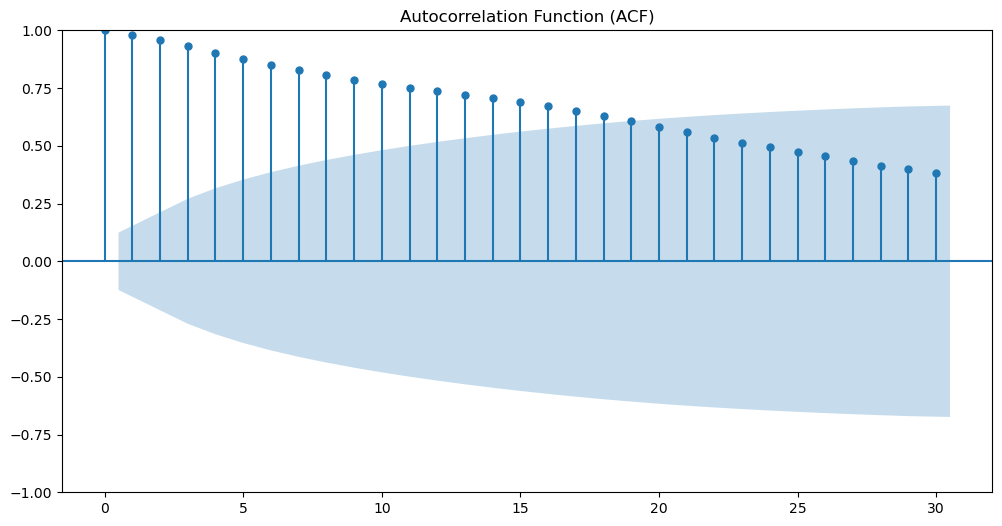

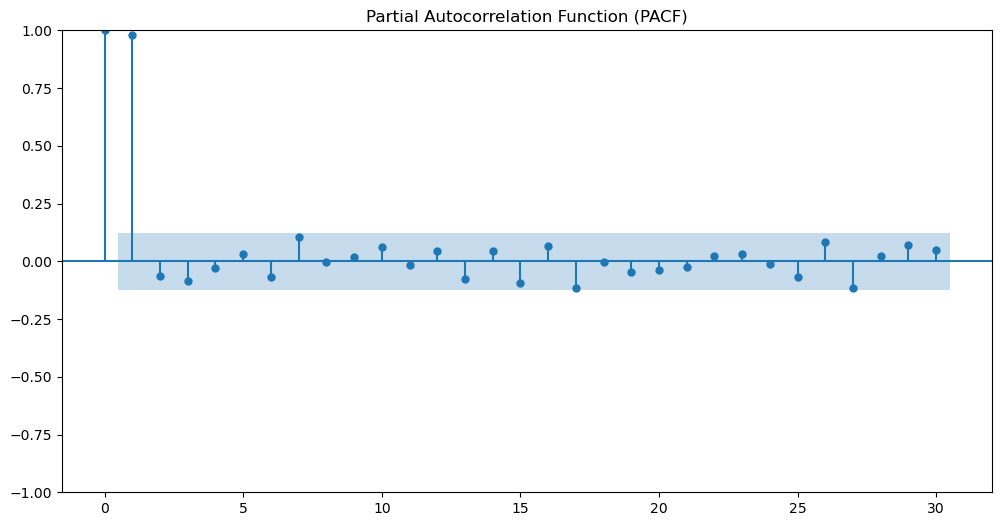

In [53]:
# Model Building - ARIMA
# Parameter Selection 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plot_acf(df['Ex_rate'], lags=30, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df['Ex_rate'], lags=30, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [96]:
# Model Fitting:
from statsmodels.tsa.arima.model import ARIMA

# Define ARIMA model
AR_model = ARIMA(df['Ex_rate'], order=(1, 1, 1))

# Fit the model
arima = AR_model.fit()
# Display summary

arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Ex_rate   No. Observations:                  249
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 537.585
Date:                Wed, 28 Aug 2024   AIC                          -1069.169
Time:                        19:33:06   BIC                          -1058.629
Sample:                    01-31-1990   HQIC                         -1064.926
                         - 09-30-2010                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5341      0.471      1.134      0.257      -0.389       1.457
ma.L1         -0.4621      0.491     -0.940      0.347      -1.425       0.501
sigma2         0.0008   5.64e-05     13.587      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                40.07
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               1.64   Skew:                            -0.44
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

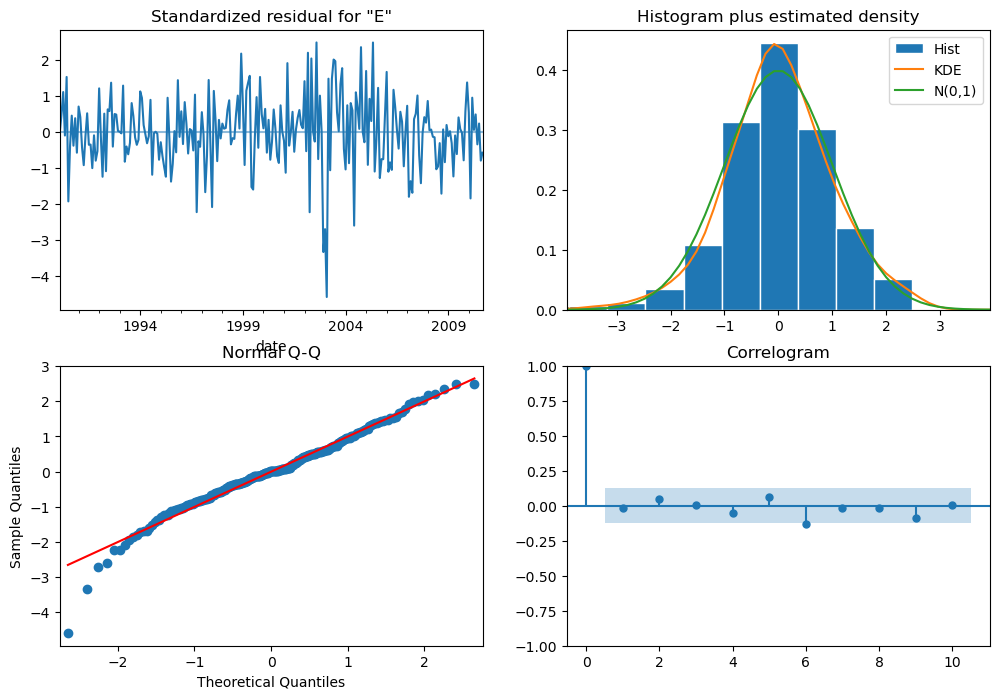

In [98]:
# Diagnostics
arima.plot_diagnostics(figsize=(12, 8))
plt.show()

In [99]:
# Forecasting
forecast = arima.get_forecast(steps=30)
forecast_index = pd.date_range(start=df.index[-1], periods=30, freq='D')

# Convert to DataFrame for plotting
forecast_df = forecast.predicted_mean
forecast_df.index = forecast_index

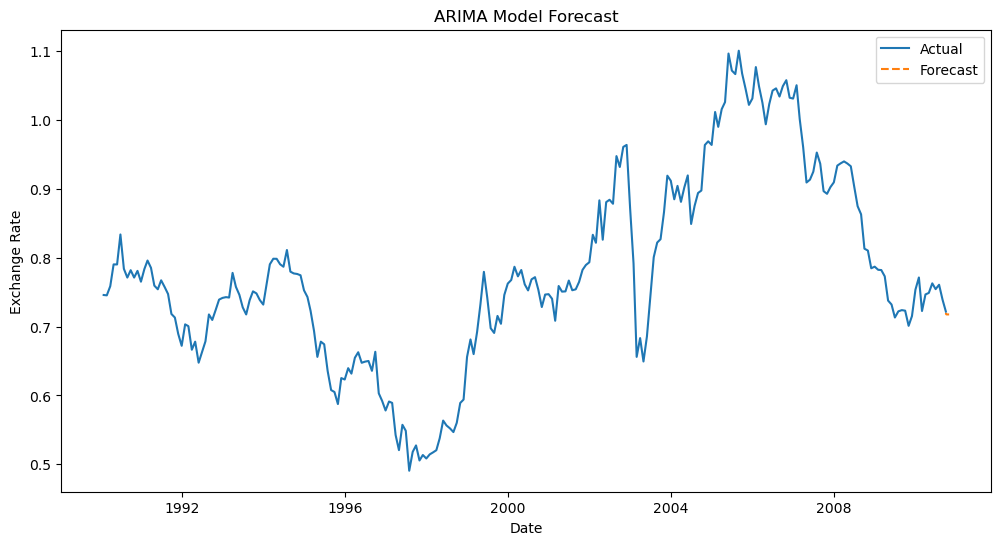

In [100]:
# Plot the forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(forecast_df, label='Forecast', linestyle='--')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [118]:
# Model Building - Exponential Smoothing
# Model Selection
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Select and define the Exponential Smoothing model (e.g., Holt-Winters)
ES_model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal='add', seasonal_periods=12)

In [131]:
# Parameter Optimization:
from sklearn.model_selection import ParameterGrid

# Define a more refined parameter grid
param_grid = {
    'trend': ['add', None],  # Remove 'mul' 
    'seasonal': ['add', None],  # Similarly, remove 'mul'
    'seasonal_periods': [12],  # Stick with 12 if you are confident it's correct
}

# Create an empty list to store the results
results = []

# Perform grid search
for params in ParameterGrid(param_grid):
    try:
        model = ExponentialSmoothing(df['Ex_rate'], **params)
        result = model.fit(optimized=True)
        aic = result.aic
        results.append((params, aic))
        print(f"Params: {params}, AIC: {aic}")
    except Exception as e:
        print(f"Model with Params: {params} failed. Error: {e}")

# Find the best parameters based on AIC
best_params = min(results, key=lambda x: x[1])
print(f"\nBest model parameters: {best_params[0]} with AIC: {best_params[1]}")


Params: {'seasonal': 'add', 'seasonal_periods': 12, 'trend': 'add'}, AIC: -1770.8439949234391
Params: {'seasonal': 'add', 'seasonal_periods': 12, 'trend': None}, AIC: -1774.8434741600513
Params: {'seasonal': None, 'seasonal_periods': 12, 'trend': 'add'}, AIC: -1777.3389550960756
Params: {'seasonal': None, 'seasonal_periods': 12, 'trend': None}, AIC: -1781.3358771724222

Best model parameters: {'seasonal': None, 'seasonal_periods': 12, 'trend': None} with AIC: -1781.3358771724222


In [122]:
# Extract the best parameters
best_trend = best_params[0]['trend']
best_seasonal = best_params[0]['seasonal']
best_seasonal_periods = best_params[0]['seasonal_periods']

# Fit the model with the best parameters
ES_model_best = ExponentialSmoothing(df['Ex_rate'], trend=best_trend, seasonal=best_seasonal, seasonal_periods=best_seasonal_periods)
ES_result_best = ES_model_best.fit(optimized=True)

# Display the model summary
ES_result_best.summary()

Dep. Variable:,Ex_rate,No. Observations:,249
Model:,ExponentialSmoothing,SSE,0.192
Optimized:,True,AIC,-1781.336
Trend:,None,BIC,-1774.301
Seasonal:,None,AICC,-1781.172
Seasonal Periods:,None,Date:,"Wed, 28 Aug 2024"
Box-Cox:,False,Time:,19:33:27
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
initial_level,0.7455707,l.0,True


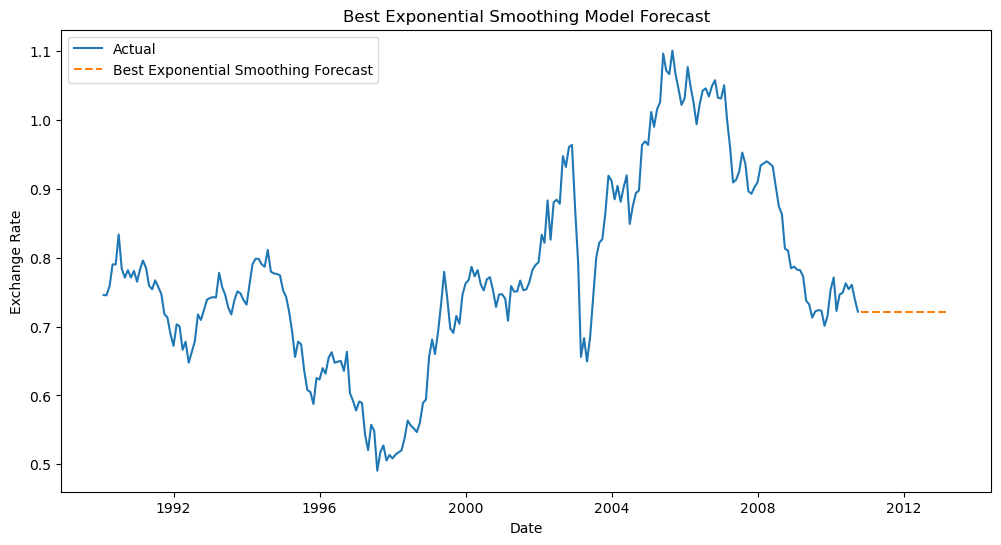

In [133]:
# Model Fitting and Forecasting
es_forecast_best = ES_result_best.forecast(steps=30)

# Plot the forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(es_forecast_best, label='Best Exponential Smoothing Forecast', linestyle='--')
plt.title('Best Exponential Smoothing Model Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [139]:
# Evaluation And Comparison
# Compute Error Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate error metrics for ARIMA model
arima_forecast_df = forecast_df[:30]  # Taking the last 30 days of forecast

# Assuming we have the actual values for the corresponding forecasted periods
actual_values = df['Ex_rate'][-30:]

arima_mae = mean_absolute_error(actual_values, arima_forecast_df)
arima_rmse = np.sqrt(mean_squared_error(actual_values, arima_forecast_df))
arima_mape = np.mean(np.abs((actual_values - arima_forecast_df) / actual_values)) * 100

print("ARIMA Model Evaluation:")
print("Mean Absolute Error (MAE):", arima_mae)
print("Root Mean Squared Error (RMSE):", arima_rmse)
print("Mean Absolute Percentage Error (MAPE):", arima_mape)

ARIMA Model Evaluation:
Mean Absolute Error (MAE): 0.06015686694674739
Root Mean Squared Error (RMSE): 0.08632793978271354
Mean Absolute Percentage Error (MAPE): 0.2600855946311301


In [128]:
# Calculate error metrics for Best Exponential Smoothing model
es_forecast_df_best = es_forecast_best[:30]  # Taking the last 30 days of forecast

es_mae = mean_absolute_error(actual_values, es_forecast_df_best)
es_rmse = np.sqrt(mean_squared_error(actual_values, es_forecast_df_best))
es_mape = np.mean(np.abs((actual_values - es_forecast_df_best) / actual_values)) * 100

print("Best Exponential Smoothing Model Evaluation:")
print("Mean Absolute Error (MAE):", es_mae)
print("Root Mean Squared Error (RMSE):", es_rmse)
print("Mean Absolute Percentage Error (MAPE):", es_mape)

Best Exponential Smoothing Model Evaluation:
Mean Absolute Error (MAE): 0.05708833314369714
Root Mean Squared Error (RMSE): 0.08400577200227706
Mean Absolute Percentage Error (MAPE): nan
